# Machine Learning Modeling


We found the best model in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/Modeling/extra_tree.ipynb). We got ROC AUC to be 0.89 and PR AUC to be 0.38. However, there were some features which seemed unnecessary such as both "Month" and "Month_Dest". There is very little diffference between the two. Also, we built the model using three types of data sources: (i) flight data, (ii) historical data, and (iii) weather data. But, we do not know which part contributes most to the predictive power. Lets explore the feature space little bit more and address these issues in this notebook.

## Loading modules

In [1]:
import pandas as pd
import numpy as np
% pylab inline
import operator
import re
from collections import OrderedDict
import seaborn as sns
import pickle
import os.path
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Setting some plot colors and parameters

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# Adapted from http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set_style('ticks')

## Setting data frame display

In [3]:
pd.set_option('display.max_columns', None)

## Loading the data

We have acquired and merged the data in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataAcquisitionMerging/data_acquisition_merging.ipynb). The merged data was also cleaned by fixing the missing values in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataCleaning/data_cleaning.ipynb). A lot of features from the cleaned data was removed (or some features were selected) in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/EDA/ExploratoryDataAnalysis_v1.ipynb). The resultant csv file is loaded below:

In [4]:
df = pd.read_csv("../Data/ExploredDataCleaned/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_ExploredCleaned.csv")

In [5]:
df.shape

(2857139, 69)

In [6]:
df.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,Carrier,Origin,Dest,Cancelled,Distance,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanDiv_30,AllCanceled_10,AllDiverted_10,AllCanDiv_10
0,0,1,1,4,AA,PHX,DFW,1.0,868.0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,4,NK,PHX,DFW,0.0,868.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,1,4,DL,DEN,ATL,0.0,1199.0,10,3.5,48.0,-7.5,52.0,15.0,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,1,4,NK,LAS,MSP,0.0,1299.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
4,4,1,1,4,NK,LAS,DFW,0.0,1055.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0


In [7]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [8]:
df.head()

,Month,DayofMonth,DayOfWeek,Carrier,Origin,Dest,Cancelled,Distance,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanDiv_30,AllCanceled_10,AllDiverted_10,AllCanDiv_10
0,1,1,4,AA,PHX,DFW,1.0,868.0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,4,NK,PHX,DFW,0.0,868.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
2,1,1,4,DL,DEN,ATL,0.0,1199.0,10,3.5,48.0,-7.5,52.0,15.0,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,4,NK,LAS,MSP,0.0,1299.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
4,1,1,4,NK,LAS,DFW,0.0,1055.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(2857139, 68)

There are some variables with numerical values and some variables with categories. For numerical variables, we do not have to worry about labelling. However, we will need to perform label encoding for the categorical variables. There are also some variables that are already in binary form, so that also does not need any labeling. Let's first identify all the numerical, categorical and binary variables.

In [10]:
numvar = ["Distance", "Nflights_10", "DepDelayMedian_10", "DepDelayMax_10", "ArrDelayMedian_10",
          "ArrDelayMax_10", "TaxiOutMedian_10", "TaxiInMedian_10", "Ncan_10", "Ndiv_10", "Nflights_20",
          "DepDelayMedian_20", "DepDelayMax_20", "ArrDelayMedian_20", "ArrDelayMax_20", "TaxiOutMedian_20",
          "TaxiInMedian_20", "Ncan_20", "Ndiv_20", "Nflights_30", "DepDelayMedian_30", "DepDelayMax_30", 
          "ArrDelayMedian_30", "ArrDelayMax_30", "TaxiOutMedian_30", "TaxiInMedian_30", "Ncan_30", 
          "Ndiv_30", "Temperature_Origin", "DewPoint_Origin", "Humidity_Origin", "WindSpeed_Origin", 
          "WindDirection_Origin", "Visibility_Origin", "Pressure_Origin", "Temperature_Dest", "DewPoint_Dest",
          "Humidity_Dest", "WindSpeed_Dest", "WindDirection_Dest", "Visibility_Dest", "Pressure_Dest"]
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Condition_Origin", "Condition_Dest", "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
binvar = ["TempFlight_30", "TempFlight_20", "TempFlight_10", "AllCanceled_30", "AllDiverted_30", 
          "AllCanceled_20", "AllDiverted_20", "AllCanDiv_20", "AllCanDiv_30", "AllCanceled_10", 
          "AllDiverted_10", "AllCanDiv_10"]

## Converting string values to numerical values in all categorical columns

In [11]:
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()
tmp = df[catvar].apply(lbl_enc.fit_transform) 

In [12]:
df.drop(catvar, axis=1, inplace=True)
df = pd.concat([df, tmp], axis=1)

In [13]:
df.shape

(2857139, 68)

In [14]:
colnames = list(df.columns[1:])

In order to separately see which data source had large predictive power, lets divide the feature space in three parts. Also, rather than experimenting with resampling techniques, number of trees, etc.., we will use the final model that we figured in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/Modeling/extra_tree.ipynb): 

Ntrees: 50

min_samples_leaf: 4

class_weight: "balanced"

One-hot encoding: Yes

Any resampling: No

In [15]:
flight_vars = ["Distance", "Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
hist_vars = ["Nflights_10", "DepDelayMedian_10", "DepDelayMax_10", "ArrDelayMedian_10",
          "ArrDelayMax_10", "TaxiOutMedian_10", "TaxiInMedian_10", "Ncan_10", "Ndiv_10", "Nflights_20",
          "DepDelayMedian_20", "DepDelayMax_20", "ArrDelayMedian_20", "ArrDelayMax_20", "TaxiOutMedian_20",
          "TaxiInMedian_20", "Ncan_20", "Ndiv_20", "Nflights_30", "DepDelayMedian_30", "DepDelayMax_30", 
          "ArrDelayMedian_30", "ArrDelayMax_30", "TaxiOutMedian_30", "TaxiInMedian_30", "Ncan_30", 
          "Ndiv_30", "TempFlight_30", "TempFlight_20", "TempFlight_10", "AllCanceled_30", "AllDiverted_30", 
          "AllCanceled_20", "AllDiverted_20", "AllCanDiv_20", "AllCanDiv_30", "AllCanceled_10", 
          "AllDiverted_10", "AllCanDiv_10"]
weather_vars = ["Temperature_Origin", "DewPoint_Origin", "Humidity_Origin", "WindSpeed_Origin", 
          "WindDirection_Origin", "Visibility_Origin", "Pressure_Origin", "Temperature_Dest", "DewPoint_Dest",
          "Humidity_Dest", "WindSpeed_Dest", "WindDirection_Dest", "Visibility_Dest", "Pressure_Dest",
                "Condition_Origin", "Condition_Dest"]

# Using only flight data

In [29]:
df_flight = df[flight_vars]
# One-hot encoding
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
for cvar in catvar:
    df_flight = pd.concat([df_flight, pd.get_dummies(df_flight[cvar], prefix=cvar, dummy_na=False)], axis=1)
    df_flight.drop([cvar], axis=1, inplace=True)
# Feature matrix and target vector
X = df_flight.values
y = df.Cancelled.astype(int).values

In [30]:
X.shape

(2857139, 201)

### Splitting the data into train (50%) and test (50%) sets

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=20)
for train_index, test_index in sss1.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [32]:
X_train.shape

(1428569, 201)

In [33]:
X_test.shape

(1428570, 201)

Just to make sure that stratified shuffle split led to train and test with same fraction of positive class, lets calculate the fractions.

In [34]:
sum(df.iloc[train_index].Cancelled == 1)/len(train_index)

0.011486319526743196

In [35]:
sum(df.iloc[test_index].Cancelled == 1)/len(test_index)

0.011487011487011487

They are indeed quite similar.

### Running the model

#####################
Test data
#####################
F1:  0.345657855276
Cohen Kappa:  0.335762020968
Brier:  0.0213822213822
LogLoss:  0.106252785425
             precision    recall  f1-score   support

          0       0.99      0.98      0.99   1412160
          1       0.27      0.49      0.35     16410

avg / total       0.99      0.98      0.98   1428570

CPU times: user 21min 2s, sys: 11.8 s, total: 21min 14s
Wall time: 3min 28s


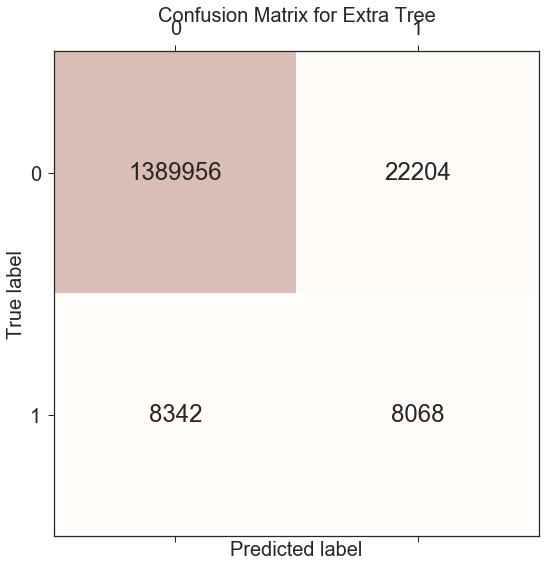

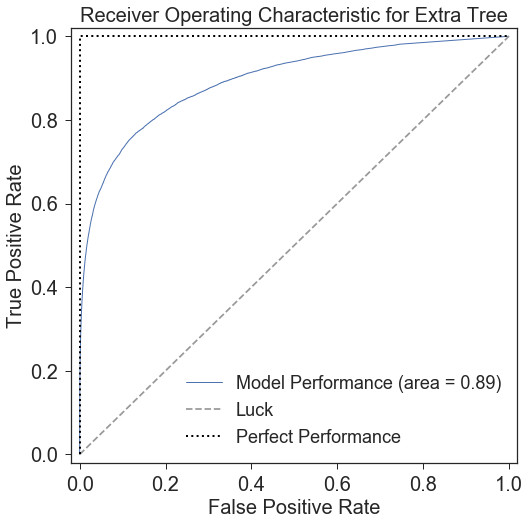

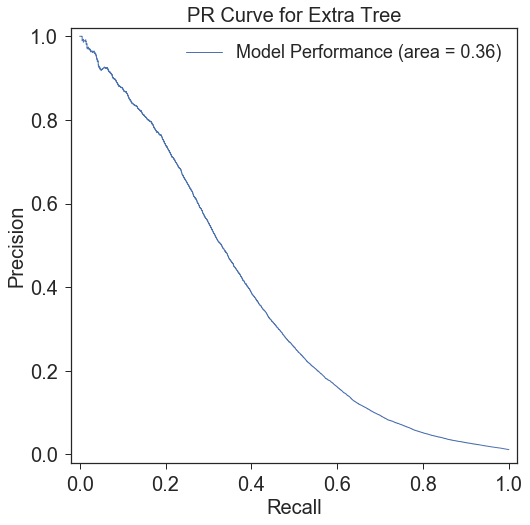

In [38]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
ET_flight = ExtraTreesClassifier(random_state=40, n_estimators = 50, min_samples_leaf=4, class_weight="balanced",
                               n_jobs=7)
ET_flight.fit(X_train, y_train)
result(ET_flight, X_train, y_train, X_test, y_test, train_result=False, clf_name="Only flight data")

This result looks quite similar to the one that we found using all three sources of data sets. This means that historical data and weather data did not really help much! How can this be true? Is there something wrong in the original model that we developed? Before investigating the original model, lets try to improve the "only flight data" model by removing some redundant features: "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest", and see if that maintains the same level of AUCs. 

#### Removing redundant features

In [39]:
df_flight = df[flight_vars]
df_flight.drop(["Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"], axis=1, inplace=True)
# One-hot encoding
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr"]
for cvar in catvar:
    df_flight = pd.concat([df_flight, pd.get_dummies(df_flight[cvar], prefix=cvar, dummy_na=False)], axis=1)
    df_flight.drop([cvar], axis=1, inplace=True)
# Feature matrix and target vector
X = df_flight.values

In [40]:
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=20)
for train_index, test_index in sss2.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#####################
Test data
#####################
F1:  0.356286116642
Cohen Kappa:  0.347265100461
Brier:  0.0185584185584
LogLoss:  0.107855232214
             precision    recall  f1-score   support

          0       0.99      0.99      0.99   1412160
          1       0.30      0.45      0.36     16410

avg / total       0.99      0.98      0.98   1428570

CPU times: user 17min 48s, sys: 8.19 s, total: 17min 56s
Wall time: 2min 50s


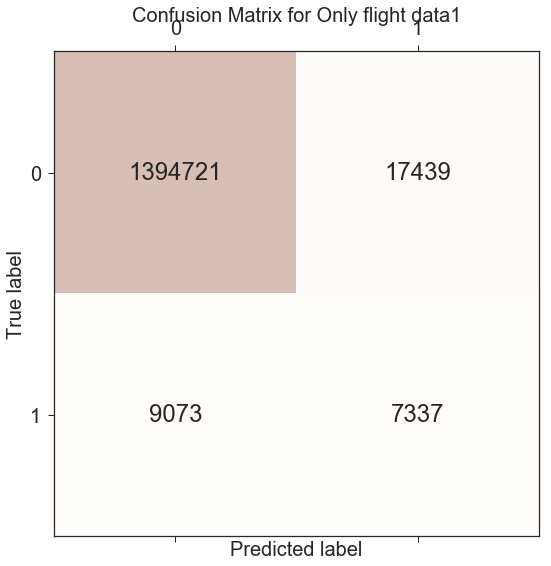

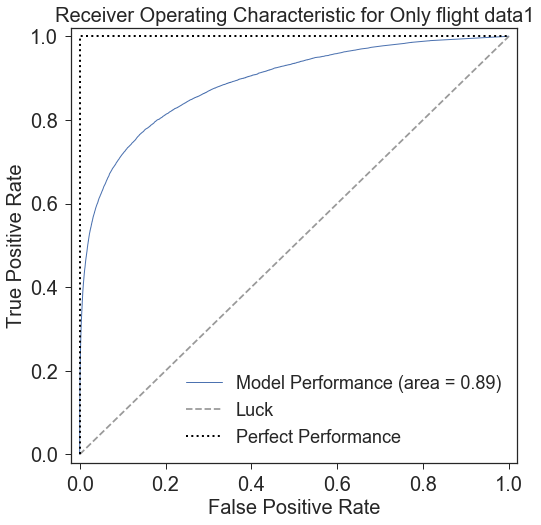

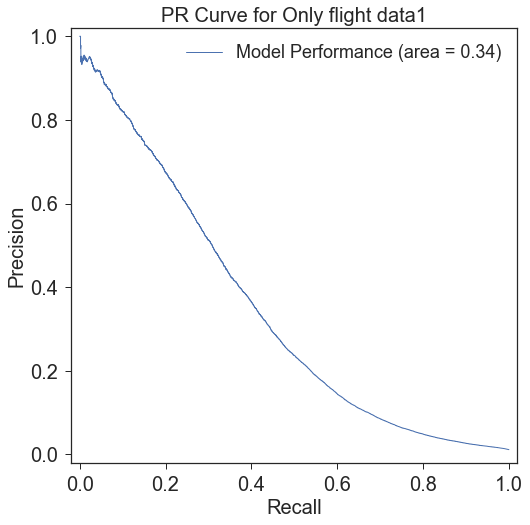

In [41]:
%%time
ET_flight1 = ExtraTreesClassifier(random_state=40, n_estimators = 50, min_samples_leaf=4, class_weight="balanced",
                               n_jobs=7)
ET_flight1.fit(X_train, y_train)
result(ET_flight1, X_train, y_train, X_test, y_test, train_result=False, clf_name="Only flight data1")

The ROC AUC is still same but the PR AUC has degraded. These redundant variables seem to be contributing to PR AUC. So, we will keep them in the model. So, for the only flight data, the model shown before the above model is the best. Lets now add the historical information and see how does that change the confusion matrix and AUCs.

# Flight data and historical data

In [45]:
df_flight_hist = df[flight_vars + hist_vars]
# One-hot encoding
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
for cvar in catvar:
    df_flight_hist = pd.concat([df_flight_hist, pd.get_dummies(df_flight_hist[cvar], prefix=cvar, dummy_na=False)], axis=1)
    df_flight_hist.drop([cvar], axis=1, inplace=True)
# Feature matrix and target vector
X = df_flight_hist.values

In [46]:
sss3 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=20)
for train_index, test_index in sss3.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#####################
Test data
#####################
F1:  0.396168108776
Cohen Kappa:  0.389252169709
Brier:  0.013678013678
LogLoss:  0.0850546682878
             precision    recall  f1-score   support

          0       0.99      0.99      0.99   1412160
          1       0.40      0.39      0.40     16410

avg / total       0.99      0.99      0.99   1428570

CPU times: user 22min 14s, sys: 11.2 s, total: 22min 25s
Wall time: 3min 34s


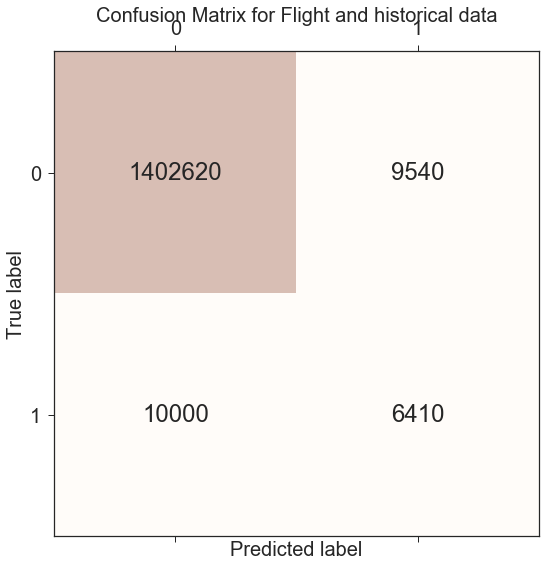

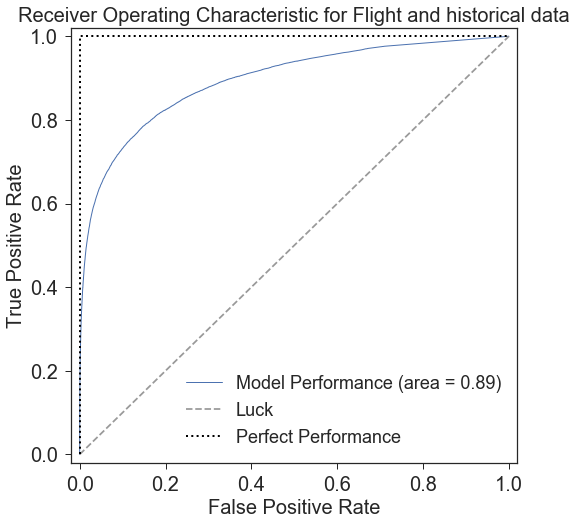

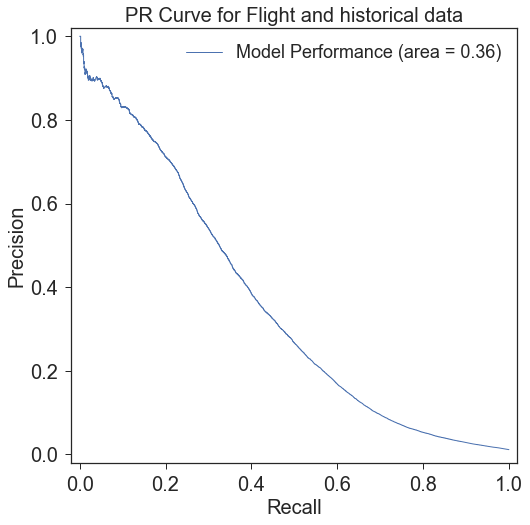

In [47]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
ET_flight_hist = ExtraTreesClassifier(random_state=40, n_estimators = 50, min_samples_leaf=4, class_weight="balanced",
                               n_jobs=7)
ET_flight_hist.fit(X_train, y_train)
result(ET_flight_hist, X_train, y_train, X_test, y_test, train_result=False, clf_name="Flight and historical data")

This means that adding the historical information did not help the model at all. So, why do we bother about it? Yes, it was a great idea to have historical information about flight performance and we spent a lot of time engineering features, but at the end, it did not improve the result. Lets now train the model using flight and weather data.

# Flight data weather data

In [48]:
df_flight_weather = df[flight_vars + weather_vars]
# One-hot encoding
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest", "Condition_Origin", "Condition_Dest"]
for cvar in catvar:
    df_flight_weather = pd.concat([df_flight_weather, pd.get_dummies(df_flight_weather[cvar], prefix=cvar, dummy_na=False)], axis=1)
    df_flight_weather.drop([cvar], axis=1, inplace=True)
# Feature matrix and target vector
X = df_flight_weather.values

In [49]:
sss4 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=20)
for train_index, test_index in sss4.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#####################
Test data
#####################
F1:  0.412544858792
Cohen Kappa:  0.405885307731
Brier:  0.0131775131775
LogLoss:  0.0834003550234
             precision    recall  f1-score   support

          0       0.99      0.99      0.99   1412160
          1       0.42      0.40      0.41     16410

avg / total       0.99      0.99      0.99   1428570

CPU times: user 25min 49s, sys: 13.3 s, total: 26min 2s
Wall time: 4min 8s


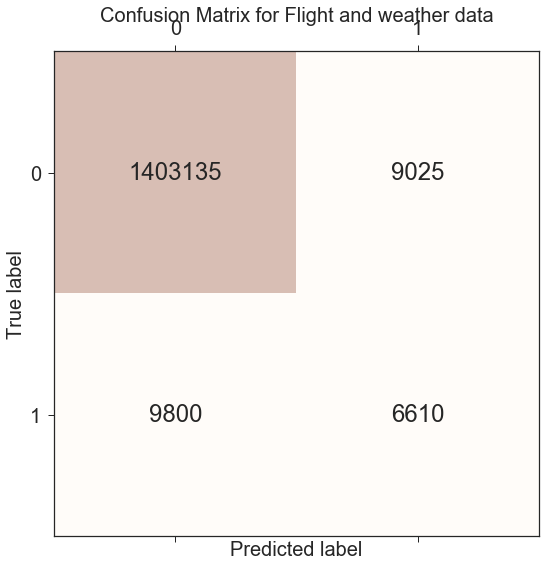

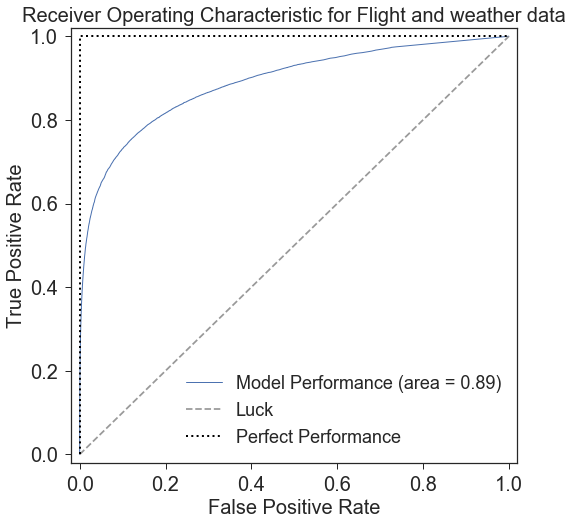

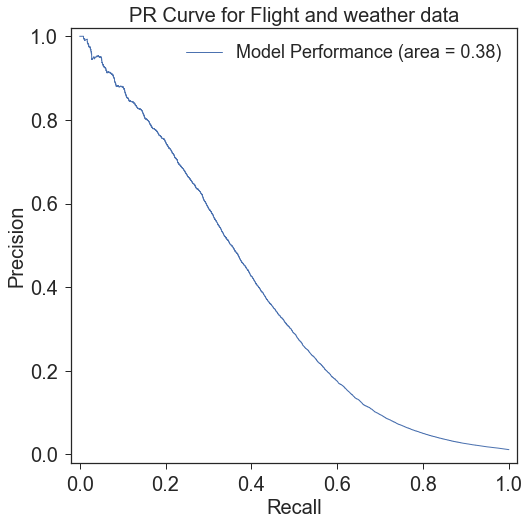

In [50]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
ET_flight_weather = ExtraTreesClassifier(random_state=40, n_estimators = 50, min_samples_leaf=4, class_weight="balanced",
                               n_jobs=7)
ET_flight_weather.fit(X_train, y_train)
result(ET_flight_weather, X_train, y_train, X_test, y_test, train_result=False, clf_name="Flight and weather data")

So, we get 0.38 PR AUC with flight and weather data and without historical data. In fact, we get the same results with using only about 30 features (mix of all three data sources) when we looked at feature importance values. We know that historical data is not contributing to the predictions. However, the feature importance values suggest that Ncan_30, Ncan_20 and Ncan_10 are important. It is therefore not very clear if we should keep them or not. For the sake of not loosing any information, we decide to kepp them. Hence, the model that built in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/Modeling/extra_tree.ipynb) is still the best we can do.

Lets try out some test data and see how our model works, and try to find out if our final model is overfitted or not!

In [53]:
import pickle
model = pickle.load(open('ExtraTree.pkl', 'rb'))

In [55]:
model

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=7,
           oob_score=False, random_state=40, verbose=0, warm_start=False)

In [56]:
df = pd.read_csv("../Data/ExploredDataCleaned/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_ExploredCleaned.csv")

In [57]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
# Removing features that have feature importance values less than 0.009
drop_them = ["ArrDelayMax_10", "DepDelayMax_10", "TaxiOutMedian_30", "TaxiOutMedian_20", "ArrDelayMax_20", 
             "ArrDelayMedian_10", "TaxiInMedian_30", "ArrDelayMedian_30", "DepDelayMax_20", "TaxiOutMedian_10",
             "TaxiInMedian_20", "ArrDelayMax_30", "ArrDelayMedian_20", "Nflights_30", "DepDelayMax_30", 
             "TaxiInMedian_10", "Nflights_20", "DepDelayMedian_30", "Nflights_10", "DepDelayMedian_20", 
             "DepDelayMedian_10", "Ndiv_30", "Ndiv_20", "Ndiv_10", "AllCanceled_10", "AllCanceled_20", 
             "AllCanceled_30", "TempFlight_10", "TempFlight_20", "TempFlight_30", "AllCanDiv_10", "AllCanDiv_30",
             "AllDiverted_30", "AllDiverted_20", "AllCanDiv_20", "AllDiverted_10"]
df.drop(drop_them, axis=1, inplace=True)
numvar = ["Distance", "DepDelayMedian_10", "DepDelayMax_10", "ArrDelayMedian_10",
          "TaxiOutMedian_10", "TaxiInMedian_10", "Ncan_10", "Ndiv_10", "DepDelayMedian_20", 
          "DepDelayMax_20", "ArrDelayMedian_20", "Ncan_20", "Ndiv_20", "Nflights_30", "DepDelayMedian_30", 
          "DepDelayMax_30", "ArrDelayMedian_30", "TaxiOutMedian_30", "TaxiInMedian_30", "Ncan_30", 
          "Ndiv_30", "Temperature_Origin", "DewPoint_Origin", "Humidity_Origin", "WindSpeed_Origin", 
          "WindDirection_Origin", "Visibility_Origin", "Pressure_Origin", "Temperature_Dest", "DewPoint_Dest",
          "Humidity_Dest", "WindSpeed_Dest", "WindDirection_Dest", "Visibility_Dest", "Pressure_Dest"]
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Condition_Origin", "Condition_Dest", "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
binvar = ["TempFlight_30", "TempFlight_20", "TempFlight_10", "AllCanceled_30", "AllCanceled_20", "AllCanceled_10"]
#OHE
for cvar in catvar:
    df = pd.concat([df, pd.get_dummies(df[cvar], prefix=cvar, dummy_na=False)], axis=1)
    df.drop([cvar], axis=1, inplace=True)

In [58]:
X = df.drop(["Cancelled"], axis=1).values
y = df.Cancelled.astype(int).values

In [59]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=10)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [95]:
# Probabilities of cancellation for all the flights that actually got cancelled (only in the test data)
pcan_test = model.predict_proba(X_test[np.where(y_test == 1)[0],:])[:,1]

(array([ 3678.,  2289.,  1539.,  1291.,  1110.,  1034.,   997.,  1166.,
         1436.,  1870.]),
 array([ 0.        ,  0.09997302,  0.19994605,  0.29991907,  0.3998921 ,
         0.49986512,  0.59983814,  0.69981117,  0.79978419,  0.89975721,
         0.99973024]),
 <a list of 10 Patch objects>)

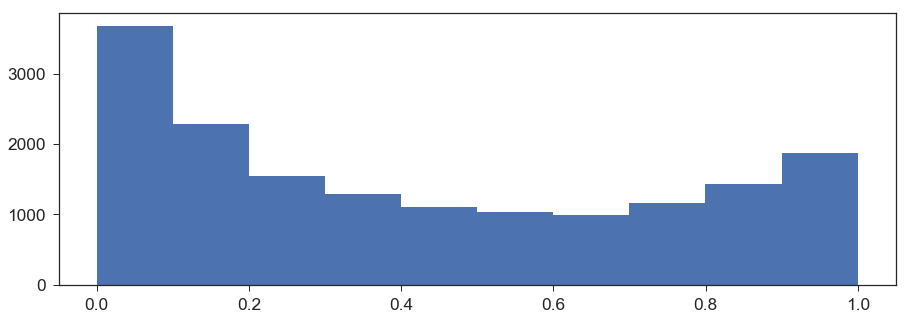

In [96]:
plt.hist(pcan_test)

In [91]:
# Probabilities of cancellation for all the flights that actually got cancelled (only in the train data)
pcan_train = model.predict_proba(X_train[np.where(y_train == 1)[0],:])[:,1]

(array([    9.,    68.,   385.,  1164.,  2200.,  2638.,  2819.,  2453.,
         2272.,  2401.]),
 array([ 0.86902689,  0.88208938,  0.89515188,  0.90821438,  0.92127688,
         0.93433938,  0.94740187,  0.96046437,  0.97352687,  0.98658937,
         0.99965187]),
 <a list of 10 Patch objects>)

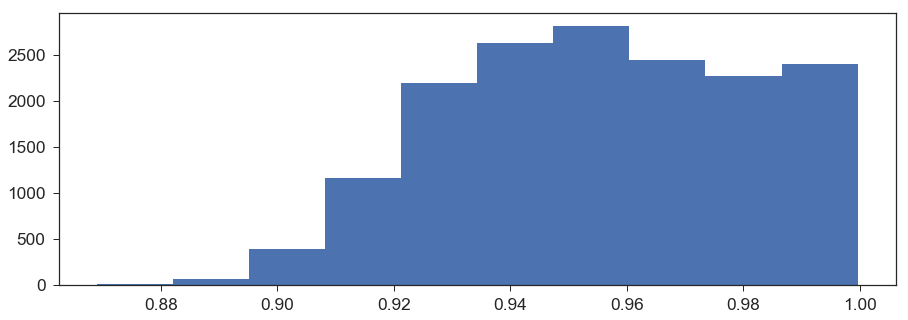

In [92]:
plt.hist(pcan_train)

We can see that training data gives very good results in terms of predicting all cancelled flights with high cancellation likelihood. However, we do not see good results with test data. This means that our final model is very much overfitted!

In [80]:
np.where(y_test == 1)[0]

array([     33,     236,     314, ..., 1428267, 1428396, 1428428])

## Function to calculate various evaluation metrics and plot ROC and PR curves

In [36]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
def result(model, X_train, y_train, X_test, y_test, train_result, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """
    if train_result:
        y_pred_train = model.predict(X_train) # class prediction
        y_pred_train_prob = model.predict_proba(X_train) # probability of each class prediction
        print("#####################")
        print("Train data")
        print("#####################")
        print("F1: ", metrics.f1_score(y_train, y_pred_train))
        print("Cohen Kappa: ", metrics.cohen_kappa_score(y_train, y_pred_train))
        print("Brier: ", metrics.brier_score_loss(y_train, y_pred_train))
        print("LogLoss: ", metrics.log_loss(y_train, y_pred_train_prob))
        print(metrics.classification_report(y_train, y_pred_train))
        print(metrics.confusion_matrix(y_train, y_pred_train))
    else:
        pass
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    print("#####################")
    print("Test data")
    print("#####################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
    print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Displaying the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    plt.title('Confusion Matrix for %s' % clf_name, size=20)
    plt.xlabel('Predicted label', size=20)
    plt.ylabel('True label', size=20)
    ax.tick_params('x', labelsize = 20)
    ax.tick_params('y', labelsize = 20)
    plt.tight_layout()
    
    # ROC curve
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
        
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('Receiver Operating Characteristic for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="lower right", fontsize=18)
    
    # PR curve
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
    #pr_auc = auc(prec, recall)
    plt.plot(recall, prec, lw=1, label='Model Performance (area = %0.2f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title('PR Curve for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="top right", fontsize=18)